<a href="https://colab.research.google.com/github/daphoon/ASAC_05_yelp_Keyword_extration_Project/blob/main/Sentimental_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 키워드 추출을 위한 textrank 구현 함수 참조
!git clone https://github.com/lovit/textrank.git

Cloning into 'Project_ASAC_5th_Review'...
fatal: could not read Username for 'https://github.com': No such device or address


### Import

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
#import ydata_profiling

### 워드 클라우드 -> 시각화
from wordcloud import WordCloud, STOPWORDS

In [ ]:
import os
import tarfile
tar_file = '/content/drive/MyDrive/ASAC/기업연계_프로젝트/yelp_dataset.tar'

# 파일 해제
if tarfile.is_tarfile(tar_file):
    with tarfile.open(tar_file) as tar:
        tar.extractall()
        print(f"{tar_file} 파일이 성공적으로 해제되었습니다.")
else:
    print(f"{tar_file} 파일은 tar 형식이 아닙니다.")

/content/drive/MyDrive/ASAC/기업연계_프로젝트/yelp_dataset.tar 파일이 성공적으로 해제되었습니다.


In [ ]:
## 리뷰 699만개

import pandas as pd
# Load the JSON file into a DataFrame with a specified encoding
reviews = pd.read_json('/content/yelp_academic_dataset_review.json',\
                        lines=True, orient='columns', chunksize=2100000)

business = pd.read_json('/content/yelp_academic_dataset_business.json',\
                        lines=True, orient='columns',chunksize=1500000)

checkins = pd.read_json('/content/yelp_academic_dataset_checkin.json',\
                        lines=True, orient='columns',encoding="utf-8",chunksize=1500000)

users = pd.read_json('/content/yelp_academic_dataset_user.json',\
                        lines=True, orient='columns',chunksize=1500000)

tips = pd.read_json('/content/yelp_academic_dataset_tip.json',\
                        lines=True, orient='columns',chunksize=1500000)
for bus in business:
  subset_business = bus
  break
# 2.4gb

for review in reviews:
  subset_review = review
  break

for checkin in checkins:
  subset_checkin = checkin
  break

for user in users:
  subset_user = user
  break

for tip in tips:
  subset_tip = tip
  break

In [ ]:
# 대문자 3개 이상 필터링 하기
# def emphasize_word(text):
#   count = 0
#   for char in text:
#     if char.isupper():
#       count += 1
#       if count >= 3:
#         return True
#     else:
#       count = 0
#   return False

# filtered_reviews = review_df.filter(pl.col("text").apply(emphasize_word))

# print(filtered_reviews.head())

In [ ]:
review_df = pd.read_csv('/content/drive/MyDrive/ASAC 데이터 분석 과정/기업연계_프로젝트/encoded_review_df_filtered.csv')

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/ASAC 데이터 분석 과정/기업연계_프로젝트/encoded_review_df_filtered.csv'

In [ ]:
df = review_df

NameError: name 'review_df' is not defined

### 별점 4,5 인 경우 긍정, 별점 3 이하인 경우 부정 리뷰로 구분

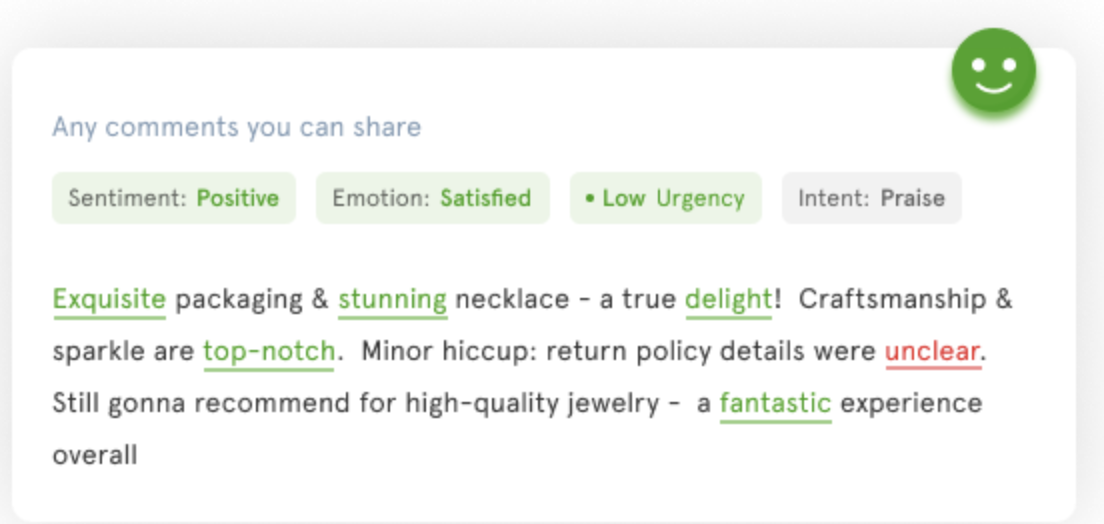

## 1. 전처리

목표
1. 고객의 리뷰 감정 분석 (긍정, 부정) 이를 활용해서 레스토랑이 좋은지, 평균인지 안좋은지 분류
2. 고객의 리뷰 감정 분석 결과를 활용하여 특정 가게에서 긍정 리뷰만 뽑아서 키워드 추출, 부정 리뷰만 뽑아서 키워드 추출을 했을 때의 결과 확인


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import ListedColormap
import seaborn as sns
from bokeh.resources import INLINE
import bokeh.io
bokeh.io.output_notebook(INLINE)
from bokeh.io import output_file, output_notebook, show
from bokeh.models import (GMapPlot, GMapOptions, ColumnDataSource, Circle, LogColorMapper,
    BasicTicker, ColorBar,DataRange1d, PanTool, Range1d, WheelZoomTool, BoxSelectTool)
from bokeh.models.mappers import ColorMapper, LinearColorMapper
from bokeh.palettes import Viridis5
import re
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk import pos_tag, pos_tag_sents
#nltk.download('wordnet')
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import sentiwordnet as swn
import tensorflow as tf
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn
from nltk import sent_tokenize, word_tokenize, pos_tag

In [ ]:
subset_business.head(3)
subset_checkin.head(3)
subset_checkin['date'][0]
tip.shape
tip.business_id.nunique()
tip.isnull().sum()
# tip에는 null값은 없음

,0
user_id,0
business_id,0
text,0
date,0
compliment_count,0


In [ ]:
business = subset_business
business.count()

business_id     150346
name            150346
address         150346
city            150346
state           150346
postal_code     150346
latitude        150346
longitude       150346
stars           150346
review_count    150346
is_open         150346
attributes      136602
categories      150243
hours           127123
dtype: int64

In [ ]:
subset_business[subset_business.is_open == 0].count()
# 30648개의 가게는 제거 필요

business_id     30648
name            30648
address         30648
city            30648
state           30648
postal_code     30648
latitude        30648
longitude       30648
stars           30648
review_count    30648
is_open         30648
attributes      29252
categories      30640
hours           23520
dtype: int64

### 레스토랑 카테고리 가게만 선별

In [ ]:
## Action:
## 1. Drop businesses which are not open (is_open == 0)
## 2. Drop businesses which are not in restaurant business (categories do not contain the keyword "food")
## 3. Drop businesses which have any missing values (remember there were 5 columns with missing values)
## 4. Create a random stratified sample of restaurants with equal weightage to 'stars' column (distinct count = 9)
## 5. Drop unnecessary columns (neighborhood, address, postal_code, is_open, categories) and reindex

def downsize_business(business):
    business.drop(business[business.is_open == 0].index, inplace = True)
    #print(business.count())
    business['categories'] = business['categories'].fillna('')
    business = business[business['categories'].str.lower().str.contains('restaurant')]
    #business1 = business.groupby('stars').apply(lambda x: x.sample(n=1000)) # 각 별점 그룹별로 20개만 뽑아서 진행해본 것. 데이터가 커지니까
    #business1.drop(business1.columns[[3, 6, 11, 12]], axis=1, inplace=True) # neighborhood는 없음
    business1 = business.reset_index(drop=True)
    return business1

business1 = downsize_business(business)
business1.head()

AttributeError: 'JsonReader' object has no attribute 'drop'

In [ ]:
business1.count()

# 44594개가 레스토랑 혹은 Food
# 3만 5천4개가 레스토랑 가게 사용할 수 있는 데이터

## 샘플된 540개로만 일단 진행

### 레스토랑 카테고리 가게의 리뷰만 모으기

In [ ]:
## Action:
## 1. Copy the unique list of business ids in a 'temp' variable
## 2. Create a new dataframe review1 having business ids in temp and keep only relevant columns
## 3. Create a new dataframe review2 with index resetting (for future operations on this dataset)

def downsize_review(review, business1):
    temp = business1['business_id'].tolist()
    review1 = review[review['business_id'].isin(temp)]
    review1 = review1[['business_id', 'stars', 'text']]
    review2 = review1.reset_index(drop=True)
    return review2

In [ ]:
review2 = downsize_review(review, business1)
review2.head()
review2.count()

In [ ]:
# 우리가 구분한 레스토랑 set으로 돌려보기
real_business = pd.read_excel('/content/drive/MyDrive/business_add_category.xlsx')
real_business.head()

,Unnamed: 0,business_id,name,address,city,state,postal_code,latitude,longitude,stars,...,attributes,categories,hours,main1,main2,main1_sub1,main1_sub2,main2_sub1,main2_sub2,category
0,0,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,...,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","['Restaurants', 'Food', 'Bubble Tea', 'Coffee ...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ...",Restaurants,Food,NaN,NaN,Bubble Tea,Coffee & Tea,"['Restaurants', nan]"
1,1,CF33F8-E6oudUQ46HnavjQ,Sonic Drive-In,615 S Main St,Ashland City,TN,37015,36.269593,-87.058943,2.0,...,"{'BusinessParking': 'None', 'BusinessAcceptsCr...","['Burgers', 'Fast Food', 'Sandwiches', 'Food',...","{'Monday': '0:0-0:0', 'Tuesday': '6:0-22:0', '...",Food,Restaurants,Ice Cream & Frozen Yogurt,NaN,Burgers,Fast Food,"['Restaurants', 'Burgers']"
2,3,bBDDEgkFA1Otx9Lfe7BZUQ,Sonic Drive-In,2312 Dickerson Pike,Nashville,TN,37207,36.208102,-86.768170,1.5,...,"{'RestaurantsAttire': ""'casual'"", 'Restaurants...","['Ice Cream & Frozen Yogurt', 'Fast Food', 'Bu...","{'Monday': '0:0-0:0', 'Tuesday': '6:0-21:0', '...",Restaurants,Food,Fast Food,Burgers,Ice Cream & Frozen Yogurt,NaN,"['Restaurants', 'Fast Food']"
3,4,eEOYSgkmpB90uNA7lDOMRA,Vietnamese Food Truck,NaN,Tampa Bay,FL,33602,27.955269,-82.456320,4.0,...,"{'Alcohol': ""'none'"", 'OutdoorSeating': 'None'...","['Vietnamese', 'Food', 'Restaurants', 'Food Tr...","{'Monday': '11:0-14:0', 'Tuesday': '11:0-14:0'...",Food,Restaurants,Food Trucks,NaN,Vietnamese,NaN,"['Restaurants', 'Vietnamese']"
4,5,il_Ro8jwPlHresjw9EGmBg,Denny's,8901 US 31 S,Indianapolis,IN,46227,39.637133,-86.127217,2.5,...,"{'RestaurantsReservations': 'False', 'Restaura...","['American (Traditional)', 'Restaurants', 'Din...","{'Monday': '6:0-22:0', 'Tuesday': '6:0-22:0', ...",Restaurants,NaN,American (Traditional),Diners,NaN,NaN,"['Restaurants', 'American (Traditional)']"


In [ ]:
real_business.drop(['Unnamed: 0'], axis=1, inplace=True)

In [ ]:
real_business

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,...,attributes,categories,hours,main1,main2,main1_sub1,main1_sub2,main2_sub1,main2_sub2,category
0,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,...,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","['Restaurants', 'Food', 'Bubble Tea', 'Coffee ...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ...",Restaurants,Food,NaN,NaN,Bubble Tea,Coffee & Tea,"['Restaurants', nan]"
1,CF33F8-E6oudUQ46HnavjQ,Sonic Drive-In,615 S Main St,Ashland City,TN,37015,36.269593,-87.058943,2.0,6,...,"{'BusinessParking': 'None', 'BusinessAcceptsCr...","['Burgers', 'Fast Food', 'Sandwiches', 'Food',...","{'Monday': '0:0-0:0', 'Tuesday': '6:0-22:0', '...",Food,Restaurants,Ice Cream & Frozen Yogurt,NaN,Burgers,Fast Food,"['Restaurants', 'Burgers']"
2,bBDDEgkFA1Otx9Lfe7BZUQ,Sonic Drive-In,2312 Dickerson Pike,Nashville,TN,37207,36.208102,-86.768170,1.5,10,...,"{'RestaurantsAttire': ""'casual'"", 'Restaurants...","['Ice Cream & Frozen Yogurt', 'Fast Food', 'Bu...","{'Monday': '0:0-0:0', 'Tuesday': '6:0-21:0', '...",Restaurants,Food,Fast Food,Burgers,Ice Cream & Frozen Yogurt,NaN,"['Restaurants', 'Fast Food']"
3,eEOYSgkmpB90uNA7lDOMRA,Vietnamese Food Truck,NaN,Tampa Bay,FL,33602,27.955269,-82.456320,4.0,10,...,"{'Alcohol': ""'none'"", 'OutdoorSeating': 'None'...","['Vietnamese', 'Food', 'Restaurants', 'Food Tr...","{'Monday': '11:0-14:0', 'Tuesday': '11:0-14:0'...",Food,Restaurants,Food Trucks,NaN,Vietnamese,NaN,"['Restaurants', 'Vietnamese']"
4,il_Ro8jwPlHresjw9EGmBg,Denny's,8901 US 31 S,Indianapolis,IN,46227,39.637133,-86.127217,2.5,28,...,"{'RestaurantsReservations': 'False', 'Restaura...","['American (Traditional)', 'Restaurants', 'Din...","{'Monday': '6:0-22:0', 'Tuesday': '6:0-22:0', ...",Restaurants,NaN,American (Traditional),Diners,NaN,NaN,"['Restaurants', 'American (Traditional)']"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33541,w_4xUt-1AyY2ZwKtnjW0Xg,Bittercreek Alehouse,246 N 8th St,Boise,ID,83702,43.616590,-116.202383,4.5,998,...,"{'BikeParking': 'True', 'Alcohol': ""u'full_bar...","['Bars', 'Gastropubs', 'Sandwiches', 'Nightlif...","{'Monday': '0:0-0:0', 'Tuesday': '11:0-22:0', ...",Nightlife,Restaurants,Bars,NaN,Gastropubs,Sandwiches,"['Restaurants', 'Gastropubs']"
33542,l9eLGG9ZKpLJzboZq-9LRQ,Wawa,19 N Bishop Ave,Clifton Heights,PA,19018,39.925656,-75.310344,3.0,11,...,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","['Restaurants', 'Sandwiches', 'Convenience Sto...","{'Monday': '0:0-0:0', 'Tuesday': '0:0-0:0', 'W...",Restaurants,Food,Sandwiches,NaN,Convenience Stores,Coffee & Tea,"['Restaurants', 'Sandwiches']"
33543,cM6V90ExQD6KMSU3rRB5ZA,Dutch Bros Coffee,1181 N Milwaukee St,Boise,ID,83704,43.615401,-116.284689,4.0,33,...,"{'WiFi': ""'free'"", 'RestaurantsGoodForGroups':...","['Cafes', 'Juice Bars & Smoothies', 'Coffee & ...","{'Monday': '0:0-0:0', 'Tuesday': '0:0-17:0', '...",Restaurants,Food,Cafes,NaN,Juice Bars & Smoothies,Coffee & Tea,"['Restaurants', 'Cafes']"
33544,WnT9NIzQgLlILjPT0kEcsQ,Adelita Taqueria & Restaurant,1108 S 9th St,Philadelphia,PA,19147,39.935982,-75.158665,4.5,35,...,"{'WheelchairAccessible': 'False', 'Restaurants...","['Restaurants', 'Mexican']","{'Monday': '11:0-22:0', 'Tuesday': '11:0-22:0'...",Restaurants,NaN,Mexican,NaN,NaN,NaN,"['Restaurants', 'Mexican']"


In [ ]:
real_review = real_business.merge(review, on='business_id', how='inner')

In [ ]:
real_review.info()

# 350만개의 리뷰 데이터, 가게는

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1062382 entries, 0 to 1062381
Data columns (total 29 columns):
 #   Column        Non-Null Count    Dtype         
---  ------        --------------    -----         
 0   business_id   1062382 non-null  object        
 1   name          1062382 non-null  object        
 2   address       1060233 non-null  object        
 3   city          1062382 non-null  object        
 4   state         1062382 non-null  object        
 5   postal_code   1062365 non-null  object        
 6   latitude      1062382 non-null  float64       
 7   longitude     1062382 non-null  float64       
 8   stars_x       1062382 non-null  float64       
 9   review_count  1062382 non-null  int64         
 10  is_open       1062382 non-null  int64         
 11  attributes    1061205 non-null  object        
 12  categories    1062382 non-null  object        
 13  hours         1042260 non-null  object        
 14  main1         1062382 non-null  object        
 15

## Sentiment Analysis

### nltk.down

In [ ]:
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('sentiwordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package sentiwordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/sentiwordnet.zip.


True

In [ ]:
## Action:

## 1. Clean the text data in review dataset
## 2. Tokenize all text to sentences and then words
## 3. Tag all the words with position tags
## 4. Convert all tags to wrodnet tags
## 5. Lemmatize the words and create synsets
## 6. Compute sentiment score (positive score - negative score)
## 7/ Return a sentiment polarity score: 1 = positive, 0 = negative

#nltk.download('punkt')
lemmatizer = WordNetLemmatizer()

def convert_tag(tag):
    if tag.startswith('J'):
        return wn.ADJ
    elif tag.startswith('N'):
        return wn.NOUN
    elif tag.startswith('R'):
        return wn.ADV
    elif tag.startswith('V'):
        return wn.VERB
    return None

def clean_text(text):
    text = text.replace("<br />", " ")
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
    text = (re.sub('[\W]+', ' ', text.lower()) + ' '.join(emoticons).replace('-', ''))
    #text = text.decode("utf-8")
    return text

def compute_swn_polarity_score(text):
    sentiment_score = 0.0
    num_tokens = 0
    text = clean_text(text)
    sentences = sent_tokenize(text)
    for sentence in sentences:
        tagged_sentence = pos_tag(word_tokenize(sentence))
        for word, tag in tagged_sentence:
            wn_tag = convert_tag(tag)
            if wn_tag not in (wn.NOUN, wn.ADJ, wn.ADV):
                continue
            lemma = lemmatizer.lemmatize(word, pos=wn_tag)
            if not lemma:
                continue
            synsets = wn.synsets(lemma, pos=wn_tag)
            if not synsets:
                continue
            synset = synsets[0]
            swn_synset = swn.senti_synset(synset.name())
            sentiment_score += swn_synset.pos_score() - swn_synset.neg_score()
            num_tokens += 1
    # sum greater than 0 => positive sentiment
    if sentiment_score >= 0:
        return 1
    # All other scenarios => negative sentiment
    else:
        return 0

In [ ]:
## Action:
## Create a new column 'polarity' with sentiment polarity as 1 (positive) or 0 (negative)
# review2['polarity'] = review2['text'].apply(compute_swn_polarity_score)
# review2.head()
## 백만개는 1시간 넘게 걸릴 것으로 예상
# 540개 가게에서 10000개 정도의 리뷰로 분석해보면 1분 정도

from tqdm import tqdm

tqdm.pandas()
# 새로운 'polarity' 열 생성
real_review['polarity'] = real_review['text'].progress_apply(compute_swn_polarity_score)

real_review[['stars', 'polarity']].groupby(['stars']).mean()
# 평균값에서 보면 별점이 1점이면 낮고, 5점은 높아지는 모습

 19%|█▉        | 688969/3550536 [55:51<3:11:25, 249.15it/s]

###

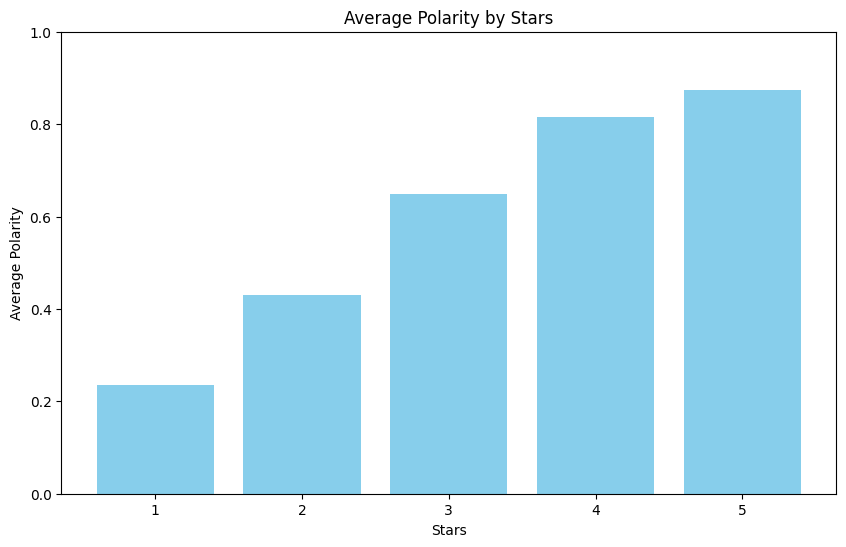

In [ ]:
mean_polarity = review2[['stars', 'polarity']].groupby(['stars']).mean()

# 그래프 그리기
plt.figure(figsize=(10, 6))
plt.bar(mean_polarity.index, mean_polarity['polarity'], color='skyblue')
plt.xlabel('Stars')
plt.ylabel('Average Polarity')
plt.title('Average Polarity by Stars')
plt.xticks(mean_polarity.index)  # x축의 틱 설정
plt.ylim(0, 1)  # y축 범위 설정 (극성 값의 범위에 따라 조정 가능)

# 그래프 출력
plt.show()

In [ ]:
review2.to_csv('/content/drive/MyDrive/sentimental_analysis_review.csv',index=False)

In [ ]:
import pandas as pd

In [ ]:
review2 = pd.read_csv('/content/drive/MyDrive/sentimental_analysis_review.csv')

In [ ]:
review2.head()

,business_id,stars,text,polarity
0,XQfwVwDr-v0ZS3_CbbE5Xw,3,"If you decide to eat here, just be aware it is...",0
1,YjUWPpI6HXG530lwP-fb2A,3,Family diner. Had the buffet. Eclectic assortm...,1
2,kxX2SOes4o-D3ZQBkiMRfA,5,"Wow! Yummy, different, delicious. Our favo...",1
3,gebiRewfieSdtt17PTW6Zg,3,Had a party of 6 here for hibachi. Our waitres...,1
4,EQ-TZ2eeD_E0BHuvoaeG5Q,4,"Locals recommended Milktooth, and it's an amaz...",1


In [ ]:
review2.head(5)

,business_id,stars,text,polarity
0,XQfwVwDr-v0ZS3_CbbE5Xw,3,"If you decide to eat here, just be aware it is...",0
1,YjUWPpI6HXG530lwP-fb2A,3,Family diner. Had the buffet. Eclectic assortm...,1
2,kxX2SOes4o-D3ZQBkiMRfA,5,"Wow! Yummy, different, delicious. Our favo...",1
3,gebiRewfieSdtt17PTW6Zg,3,Had a party of 6 here for hibachi. Our waitres...,1
4,EQ-TZ2eeD_E0BHuvoaeG5Q,4,"Locals recommended Milktooth, and it's an amaz...",1


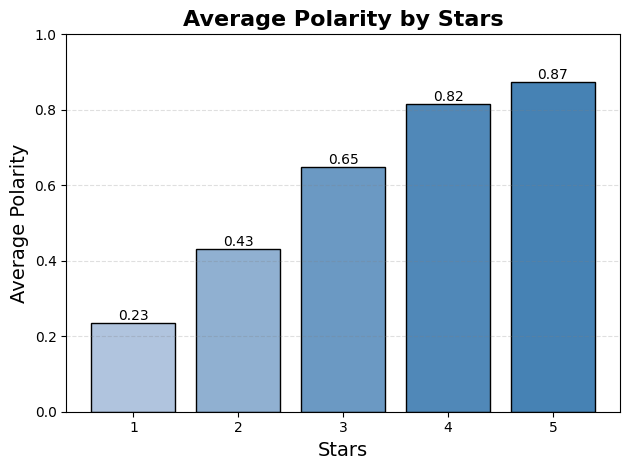

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

mean_polarity = review2[['stars', 'polarity']].groupby(['stars']).mean()

fig, ax = plt.subplots()

# Normalize the height values for color mapping
norm = plt.Normalize(mean_polarity['polarity'].min(), mean_polarity['polarity'].max())

# Define a custom colormap for steelblue to lightsteelblue gradient
cmap = mcolors.LinearSegmentedColormap.from_list("", ["lightsteelblue", "steelblue"])

# Bar chart with gradient color based on height
bars = ax.bar(mean_polarity.index, mean_polarity['polarity'], color=cmap(norm(mean_polarity['polarity'])), edgecolor='black')

# Add data labels on top of bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.2f}', ha='center', va='bottom')

# Add horizontal grid lines
ax.yaxis.grid(True, linestyle='--', which='major', color='grey', alpha=.25)

# Customize the fonts
plt.title('Average Polarity by Stars', fontsize=16, fontweight='bold')
plt.xlabel('Stars', fontsize=14)
plt.ylabel('Average Polarity', fontsize=14)

# Set the y-axis limit
ax.set_ylim(0, 1)

# Show plot
plt.tight_layout()
plt.show()


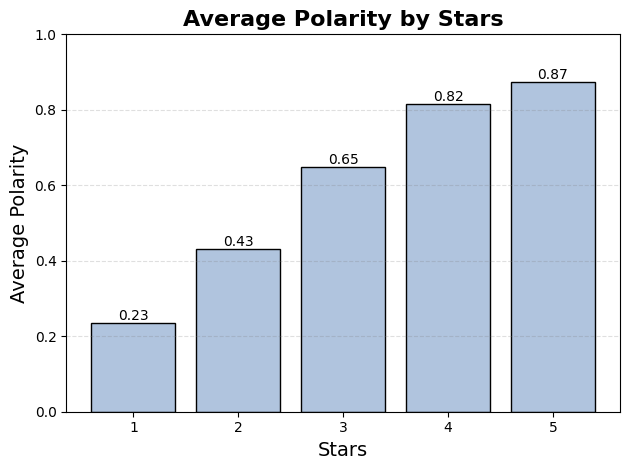

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

mean_polarity = review2[['stars', 'polarity']].groupby(['stars']).mean()

fig, ax = plt.subplots()

# Bar chart with customized color
bars = ax.bar(mean_polarity.index, mean_polarity['polarity'], color='lightsteelblue', edgecolor='black')

# Add data labels on top of bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.2f}', ha='center', va='bottom')

# Add horizontal grid lines
ax.yaxis.grid(True, linestyle='--', which='major', color='grey', alpha=.25)

# Customize the fonts
plt.title('Average Polarity by Stars', fontsize=16, fontweight='bold')
plt.xlabel('Stars', fontsize=14)
plt.ylabel('Average Polarity', fontsize=14)

# Set the y-axis limit
ax.set_ylim(0, 1)

# Show plot
plt.tight_layout()
plt.show()


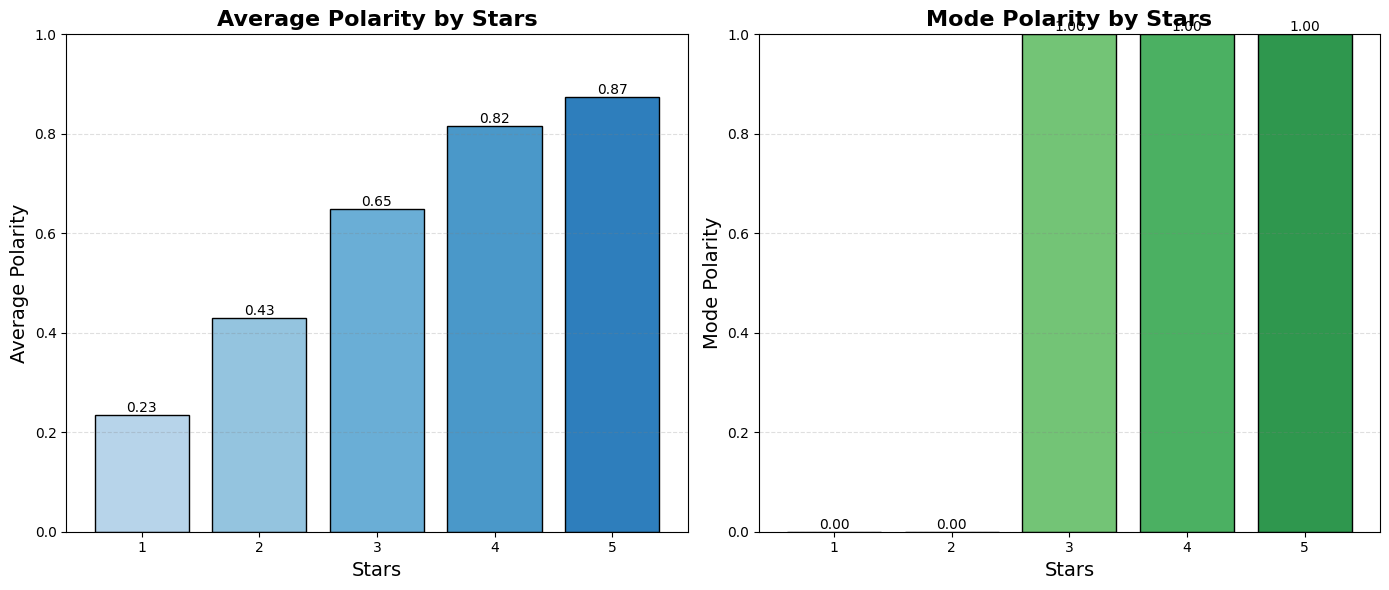

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# 평균 polarity 계산
mean_polarity = review2[['stars', 'polarity']].groupby(['stars']).mean()

# 최빈 polarity 계산
mode_polarity = review2.groupby('stars')['polarity'].apply(lambda x: Counter(x).most_common(1)[0][0])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# 평균 polarity 그래프
bars1 = ax1.bar(mean_polarity.index, mean_polarity['polarity'], color=plt.cm.Blues(np.linspace(0.3, 0.7, len(mean_polarity.index))), edgecolor='black')

# 데이터 라벨 추가
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.2f}', ha='center', va='bottom')

# 평균 polarity 그래프 설정
ax1.yaxis.grid(True, linestyle='--', which='major', color='grey', alpha=.25)
ax1.set_title('Average Polarity by Stars', fontsize=16, fontweight='bold')
ax1.set_xlabel('Stars', fontsize=14)
ax1.set_ylabel('Average Polarity', fontsize=14)
ax1.set_ylim(0, 1)

# 최빈 polarity 그래프
bars2 = ax2.bar(mode_polarity.index, mode_polarity, color=plt.cm.Greens(np.linspace(0.3, 0.7, len(mode_polarity.index))), edgecolor='black')

# 데이터 라벨 추가
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.2f}', ha='center', va='bottom')

# 최빈 polarity 그래프 설정
ax2.yaxis.grid(True, linestyle='--', which='major', color='grey', alpha=.25)
ax2.set_title('Mode Polarity by Stars', fontsize=16, fontweight='bold')
ax2.set_xlabel('Stars', fontsize=14)
ax2.set_ylabel('Mode Polarity', fontsize=14)
ax2.set_ylim(0, 1)

# 레이아웃 조정 및 그래프 표시
plt.tight_layout()
plt.show()

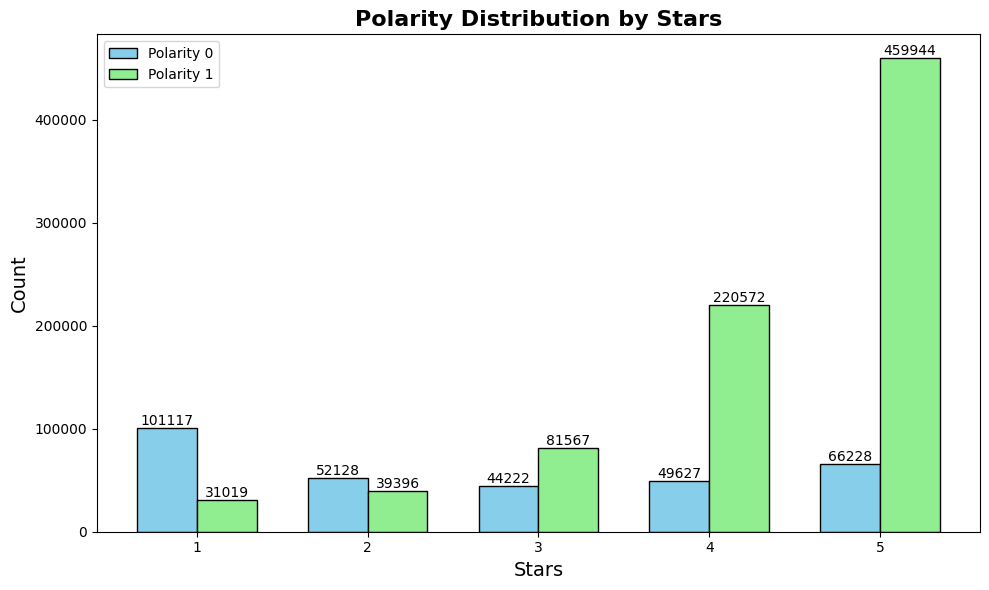

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 별점별 polarity가 0과 1인 경우의 수를 계산
polarity_counts = review2.groupby(['stars', 'polarity']).size().unstack(fill_value=0)

fig, ax = plt.subplots(figsize=(10, 6))

# 0과 1에 해당하는 막대 그래프를 나란히 표시
width = 0.35
stars = np.arange(1, 6)
bar1 = ax.bar(stars - width/2, polarity_counts[0], width, label='Polarity 0', color='skyblue', edgecolor='black')
bar2 = ax.bar(stars + width/2, polarity_counts[1], width, label='Polarity 1', color='lightgreen', edgecolor='black')

# 데이터 라벨 추가
for bar in bar1 + bar2:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height}', ha='center', va='bottom')

# 그래프 설정
ax.set_title('Polarity Distribution by Stars', fontsize=16, fontweight='bold')
ax.set_xlabel('Stars', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
ax.set_xticks(stars)
ax.set_xticklabels(stars)
ax.legend()

# 레이아웃 조정 및 그래프 표시
plt.tight_layout()
plt.show()

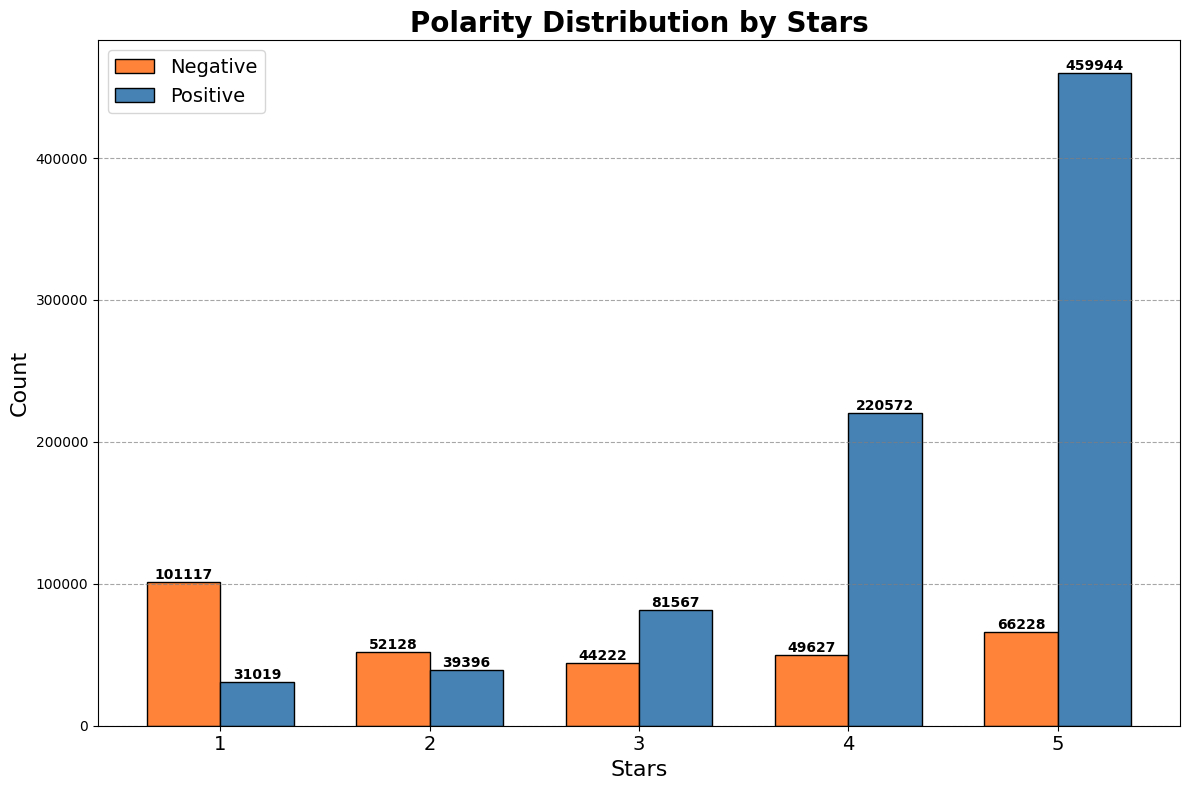

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 별점별 polarity가 0과 1인 경우의 수를 계산
polarity_counts = review2.groupby(['stars', 'polarity']).size().unstack(fill_value=0)

fig, ax = plt.subplots(figsize=(12, 8))

# 0과 1에 해당하는 막대 그래프를 나란히 표시
width = 0.35
stars = np.arange(1, 6)
bar1 = ax.bar(stars - width/2, polarity_counts[0], width, label='Negative', color='#FF8339', edgecolor='black')
bar2 = ax.bar(stars + width/2, polarity_counts[1], width, label='Positive', color='steelblue', edgecolor='black')

# 데이터 라벨 추가
for bar in bar1 + bar2:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 그래프 설정
ax.set_title('Polarity Distribution by Stars', fontsize=20, fontweight='bold')
ax.set_xlabel('Stars', fontsize=16)
ax.set_ylabel('Count', fontsize=16)
ax.set_xticks(stars)
ax.set_xticklabels(stars, fontsize=14)
ax.yaxis.grid(True, linestyle='--', which='major', color='grey', alpha=0.7)
ax.legend(fontsize=14)

# 레이아웃 조정 및 그래프 표시
plt.tight_layout()
plt.show()

In [ ]:
review2.count()

business_id    1145820
stars          1145820
text           1145820
polarity       1145820
dtype: int64

In [ ]:
review3 = review2.drop(['text'], axis=1)

In [ ]:
review3.shape

(1145820, 3)

In [ ]:
review3.head(1)

,business_id,stars,polarity
0,XQfwVwDr-v0ZS3_CbbE5Xw,3,0


In [ ]:
## Action:
## 1. Create a new dataframe review3 by averaging all columns
## 2. Reset index
## 3. Round up the 'stars' and 'polarity' columns to 2 decimals
## 4. Rename 'polarity' column to 'net_positive_sentiment' and 'stars' to 'review_stars'

def transform_review(review3):
    review4 = review3.groupby('business_id').mean().reset_index()
    #review3['stars'].round(2)
    review4['stars'] = review4['stars'].apply(lambda x: round(x,2))
    review4['polarity'] = review4['polarity'].apply(lambda x: round(x,2))
    review4.rename(columns={'polarity':'net_positive_sentiment_score'}, inplace=True)
    review4.rename(columns={'stars':'review_stars'}, inplace=True)
    return review4
review4 = transform_review(review3)
review4.head()

,business_id,review_stars,net_positive_sentiment_score
0,---kPU91CF4Lq2-WlRu9Lw,4.50,0.79
1,--hF_3v1JmU9nlu4zfXJ8Q,4.73,0.87
2,-0TffRSXXIlBYVbb5AwfTg,4.36,0.87
3,-0jzoPt3UeXn6FUXVQvyPg,4.45,0.88
4,-1MhPXk1FglglUAmuPLIGg,3.88,0.82


In [ ]:
review4.shape

(10527, 2)

In [ ]:
a = review4.drop(['business_id'], axis=1, inplace=False)

In [ ]:
review4.corr()

# 둘 사이의 상관관계는 매우 높음!
# 가게의 평점과 가게에서 받은 긍부정 감성에 대한 수준

,review_stars,net_positive_sentiment_score
review_stars,1.000000,0.852729
net_positive_sentiment_score,0.852729,1.000000


### 가설 : 대문자 3개를 포함하는 리뷰가 있다면 더 중요한 리뷰일 가능성이 있으니, 포함해야한다.

- 대문자 3개가 포함된 리뷰가 평점과 상관관계를 가지고 있다면 이는 좋은 리뷰인지 나쁜 리뷰인지 확인
- 대문자 3개가 포함된 리뷰라면 1, 아니면 0을 부여 한 뒤 상관관계가 있는지 확인해보면 어떨까


In [ ]:
# 대문자가 연속으로 3개 있는 경우만 가져오는 코드
def emphasize_word(text):
  count = 0
  for char in text:
    if char.isupper():
      count += 1
      if count >= 3:
        return True
    else:
      count = 0
  return False

In [ ]:
#filtered_reviews = review2.filter(review2["text"].apply(emphasize_word))
filtered_reviews = review2[review2["text"].apply(emphasize_word)]
filtered_reviews.head()

,business_id,stars,text,polarity
26,W4ZEKkva9HpAdZG88juwyQ,3,"In a word... ""OVERRATED!"". The food took fore...",1
34,SZU9c8V2GuREDN5KgyHFJw,5,We were a bit weary about trying the Shellfish...,1
35,oQ5CPRt0R3AzFvcjNOqB1w,3,Honestly the food doesn't knock my socks off b...,1
39,EpREWeEpmR8f1qLHzzF0AA,5,After living in the STL area for way over 10 y...,1
50,f4PA-f1tcN1bIpZJLdFsQQ,5,"I must admit, I wasn't expecting much. This pl...",1


In [ ]:
filtered_reviews.reset_index(drop=True, inplace=True)

In [ ]:
filtered_reviews
#242912 개

,business_id,stars,text,polarity
0,W4ZEKkva9HpAdZG88juwyQ,3,"In a word... ""OVERRATED!"". The food took fore...",1
1,SZU9c8V2GuREDN5KgyHFJw,5,We were a bit weary about trying the Shellfish...,1
2,oQ5CPRt0R3AzFvcjNOqB1w,3,Honestly the food doesn't knock my socks off b...,1
3,EpREWeEpmR8f1qLHzzF0AA,5,After living in the STL area for way over 10 y...,1
4,f4PA-f1tcN1bIpZJLdFsQQ,5,"I must admit, I wasn't expecting much. This pl...",1
...,...,...,...,...
242907,EYs_T4NU2BbaUF7vUDI55Q,5,Jalapeño appetizers are to die for! I recommen...,1
242908,6Hqs_ncxV_SJDKvY9ISTUA,1,Went last night for COVID restaurant lifting t...,0
242909,YwezxSSXcrT5GOTI5MddPg,5,When your out of town guests come in from Clev...,0
242910,9KnTKfl4_XH5HuprnIgMBw,4,"We've made a terrible, 10 year mistake. We've ...",0


In [ ]:
filtered_reviews2 = filtered_reviews.drop(['text'], axis=1)

In [ ]:
## Action:
## 1. Create a new dataframe review3 by averaging all columns
## 2. Reset index
## 3. Round up the 'stars' and 'polarity' columns to 2 decimals
## 4. Rename 'polarity' column to 'net_positive_sentiment' and 'stars' to 'review_stars'

def transform_review(review3):
    review4 = review3.groupby('business_id').mean().reset_index()
    #review3['stars'].round(2)
    review4['stars'] = review4['stars'].apply(lambda x: round(x,2))
    review4['polarity'] = review4['polarity'].apply(lambda x: round(x,2))
    review4.rename(columns={'polarity':'net_positive_sentiment_score'}, inplace=True)
    review4.rename(columns={'stars':'review_stars'}, inplace=True)
    return review4

In [ ]:
filtered_review3 = transform_review(filtered_reviews2)
filtered_review3.head()

,business_id,review_stars,net_positive_sentiment_score
0,---kPU91CF4Lq2-WlRu9Lw,4.70,0.70
1,--hF_3v1JmU9nlu4zfXJ8Q,4.50,1.00
2,-0TffRSXXIlBYVbb5AwfTg,4.38,0.90
3,-0jzoPt3UeXn6FUXVQvyPg,4.41,0.73
4,-1MhPXk1FglglUAmuPLIGg,4.05,0.80


In [ ]:
filtered_review3.drop(['business_id'],axis=1).corr()

### 상관 계수가 낮아지는 형태가 되었는데,

,review_stars,net_positive_sentiment_score
review_stars,1.0000,0.7032
net_positive_sentiment_score,0.7032,1.0000


In [ ]:
review2[review2['stars'] <= 3.0].count()

## 349449개
## 35만개

business_id    349449
stars          349449
text           349449
polarity       349449
dtype: int64

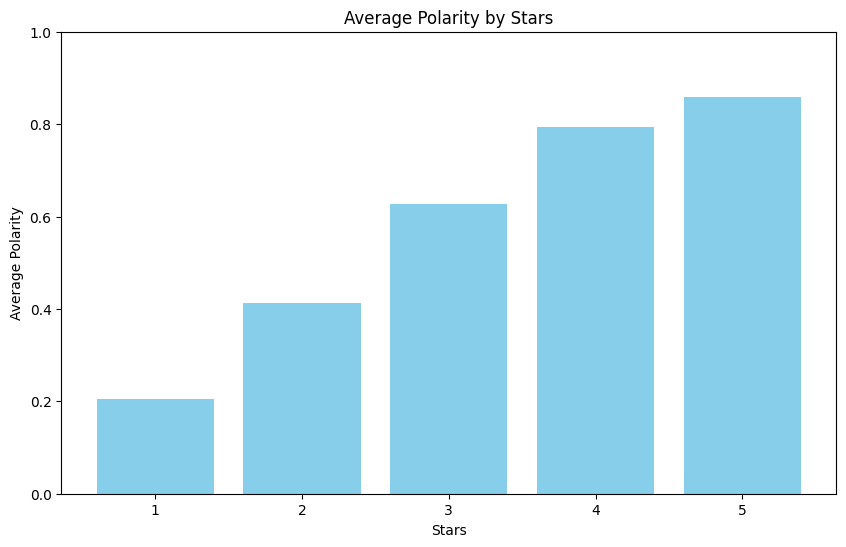

In [ ]:
mean_polarity = filtered_reviews[['stars', 'polarity']].groupby(['stars']).mean()

# 대문자가 3개 포함된 그래프 그리기
plt.figure(figsize=(10, 6))
plt.bar(mean_polarity.index, mean_polarity['polarity'], color='skyblue')
plt.xlabel('Stars')
plt.ylabel('Average Polarity')
plt.title('Average Polarity by Stars')
plt.xticks(mean_polarity.index)  # x축의 틱 설정
plt.ylim(0, 1)  # y축 범위 설정 (극성 값의 범위에 따라 조정 가능)

# 그래프 출력
plt.show()

### 이후에 할 내용

리뷰들을 평점, 감정을 통해 분류한 뒤 분류된 리뷰에서 뽑은 키워드가 그냥 뽑았을 떄와는 어떻게 차이나는지 확인 해보기


- 감정 점수가 0.5점 초과인 리뷰로 가게 키워드 추출 : 긍정 키워드 1
- 평점이 4점 이상인 리뷰로 가게별 키워드 추출 : 긍정 키워드 2


- 감정 점수가 0.5 이하인 리뷰 -> 가게 키워드 추출 : 부정 키워드 1
- 평점이 3점 이하인 리뷰 -> 가게 키워드 추출 : 부정 키워드 2

In [ ]:
negative = review2[review2['polarity'] == 0] # 부정 리뷰

#키워드 추출 시도

,business_id,stars,text,polarity
0,XQfwVwDr-v0ZS3_CbbE5Xw,3,"If you decide to eat here, just be aware it is...",0
6,otQS34_MymijPTdNBoBdCw,4,The bun makes the Sonoran Dog. It's like a snu...,0
15,S2Ho8yLxhKAa26pBAm6rxA,3,"Service was crappy, and food was mediocre. I ...",0
22,kq5Ghhh14r-eCxlVmlyd8w,5,My boyfriend and I tried this deli for the fir...,0
23,Zx7n8mdt8OzLRXVzolXNhQ,5,Amazing biscuits and (fill in the blank). Grea...,0
...,...,...,...,...
1145802,WmbwdluLzN8qXfYjYKPkqA,5,"Yes, back again and never disappointed! \nShar...",0
1145812,9KnTKfl4_XH5HuprnIgMBw,4,"We've made a terrible, 10 year mistake. We've ...",0
1145815,Un-UDVOuv1co3TMmGaumxA,2,The view was lovely! The food we ordered was n...,0
1145816,Tkx1AiQarmw0zc50GibtTA,1,Not looking for anything but quick divery anc...,0


In [ ]:
from nltk.tokenize import PunktSentenceTokenizer, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
import re
from collections import Counter
from collections import defaultdict
import networkx as nx

def kw_extract(text):
    processed_text = [preprocess(s) for s in PunktSentenceTokenizer().tokenize(text)]
    sents = [sent.split() for sent in processed_text]

    idx_to_vocab, vocab_to_idx = scan_vocabulary(sents, min_count=2)
    graph = cooccurrence(sents, vocab_to_idx, window=8, min_cooccurrence=2)
    scores = calculate_score(graph)

    R = sorted(scores.items(), key=lambda x: -x[1])[:30]
    KeyWords = ', '.join([idx_to_vocab[idx] for idx, _ in R])
    if KeyWords.isspace() and len(KeyWords.split()) < 1:
        KeyWords = '해당 텍스트의 키워드는 존재하지 않습니다. (ex. 지나치게 짧은 텍스트 등)'

    return KeyWords

def preprocess(sentence):
    sentence = sentence.lower()
    sentence = ''.join([c for c in sentence if c.isalnum() or c.isspace()])
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(sentence)
    filtered_words = [word for word in words if word not in stop_words and word]

    pos_tags = pos_tag(filtered_words)
    pos_tags = [(word, 'a') if pos.startswith('J') else (word, pos.lower()) for word, pos in pos_tags]
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word, pos=tag[0]) if tag[0] in ['n', 'v', 'a', 'r', ] else word for word, tag in pos_tags]

    return ' '.join(words)

def scan_vocabulary(sents, min_count=2):
    counter = Counter(w for sent in sents for w in sent)
    counter = {w:c for w,c in counter.items() if c >= min_count}
    idx_to_vocab = [w for w, _ in sorted(counter.items(), key=lambda x:-x[1])]
    vocab_to_idx = {vocab:idx for idx, vocab in enumerate(idx_to_vocab)}
    return idx_to_vocab, vocab_to_idx

def cooccurrence(tokens, vocab_to_idx, window=2, min_cooccurrence=2):
    counter = defaultdict(int)
    for s, tokens_i in enumerate(tokens):
        vocabs = [vocab_to_idx[w] for w in tokens_i if w in vocab_to_idx]
        n = len(vocabs)
        for i, v in enumerate(vocabs):
            if window <= 0:
                b, e = 0, n
            else:
                b = max(0, i - window)
                e = min(i + window, n)
            for j in range(b, e):
                if i == j:
                    continue
                counter[(v, vocabs[j])] += 1
                counter[(vocabs[j], v)] += 1
    counter = {k:v for k,v in counter.items() if v >= min_cooccurrence}

    nx_graph = nx.Graph()
    for (word1, word2), count in counter.items():
        nx_graph.add_edge(word1, word2, weight=count)

    return nx_graph

def calculate_score(graph):
    scores = nx.pagerank(graph)
    return scores

In [ ]:
review2.columns

Index(['business_id', 'stars', 'text', 'polarity'], dtype='object')

In [ ]:
combined_reviews = review2.groupby('business_id').agg({
    'text': ' '.join,
    'stars': 'mean',  # 필요 시 다른 컬럼도 aggregation 적용 가능
    'polarity': 'mean'  # 예시로 mean을 사용하였으나 다른 aggregation 함수도 사용 가능
}).reset_index()

print(combined_reviews)

In [ ]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
review2['text'][10522]

"This place came highly recommended by friends. After a morning of driving, I was ready to devour some amazing food. The boozy milkshake stole the show. My husband had a milkshake without alcohol, which was also stupid good. The fries and the homemade sauces were also delicious. I wish the fries were a bit warmer, but hey, fries are fries! We both got burgers. When looking at the menu, we thought the amount of ingredients would = a ton of flavor, but that wasn't the case. Both burgers, cooked medium, were just okay. Not a ton of flavor, nothing special. They were both beef, so if we went back Id try one of the other meats. All in all, the milkshakes alone are a reason to check this place out!"

### 각 가게의 긍정 리뷰를 모두 합쳐서 키워드를 추출

- why? 한개의 일반 리뷰에서는 키워드 추출이 안될 수 있으므로

In [ ]:
kw_extract(combined_reviews['text'][10522])

'order, pizza, time, place, go, make, get, always, say, night, never, phone, want, driver, 2, 10, late, call, delivery, pepperoni, food, dont, packet, minute, 30, literally, could, every, hot, eat'

### TextRank 핵심문장 추출 및 전처리 함수

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def keysentence_Extractor(text):
    glove_dict = dict()
    f = open('/content/yelp_academic_dataset_review.json', encoding="utf-8") # 100차원 GloVe 벡터 사용

    for line in f:
        word_vector = line.split()
        word = word_vector[0]
        try:
          word_vector_arr = np.asarray(word_vector[1:], dtype='float32')
          glove_dict[word] = word_vector_arr
        except ValueError:
          continue
    #     word_vector_arr = np.asarray(word_vector[1:], dtype='float32')
    #     glove_dict[word] = word_vector_arr
    # f.close()

    embedding_dim = 100
    zero_vector = np.zeros(embedding_dim)

    # 단어 벡터의 평균으로부터 문장 벡터를 계산 -> 중첩 함수
    def calculate_sentence_vector(sentence):
        return sum([glove_dict.get(word, zero_vector) for word in sentence])/len(sentence)

    def sentences_to_vectors(sentences):
        return [calculate_sentence_vector(sentence) for sentence in sentences]

    # 문장 간 코사인 유사도 계산
    def similarity_matrix(sentence_embedding):
        sim_mat = np.zeros([len(sentence_embedding), len(sentence_embedding)])

        for i in range(len(sentence_embedding)):
            for j in range(len(sentence_embedding)):
                sim_mat[i][j] = cosine_similarity(sentence_embedding[i].reshape(1, embedding_dim), sentence_embedding[j].reshape(1, embedding_dim))[0,0]

        return sim_mat

    # page-rank 기반 점수 산정
    def calculate_score(sim_matrix):
        nx_graph = nx.from_numpy_array(sim_matrix)
        scores = nx.pagerank(nx_graph)
        return scores

    processed_text = [preprocess(s) for s in PunktSentenceTokenizer().tokenize(text)]
    sentences = [sent.split() for sent in processed_text]
    SentenceEmbedding = sentences_to_vectors(sentences)
    SimMatrix = similarity_matrix(SentenceEmbedding)
    scores = calculate_score(SimMatrix).items()
    top_3_sent_idx = sorted(scores, key=lambda x: -x[1])[:3]

    original_sentences = PunktSentenceTokenizer().tokenize(text)
    summary = ""
    for idx, _ in top_3_sent_idx:
        summary += original_sentences[idx]+'\n\n'

    return summary

In [ ]:
from collections import Counter
from scipy.sparse import csr_matrix
import math

def sent_graph(sents, tokenize, similarity, min_count=2, min_sim=0.3):
    _, vocab_to_idx = scan_vocabulary(sents, tokenize, min_count)

    tokens = [[w for w in tokenize(sent) if w in vocab_to_idx] for sent in sents]
    rows, cols, data = [], [], []
    n_sents = len(tokens)
    for i, tokens_i in enumerate(tokens):
        for j, tokens_j in enumerate(tokens):
            if i >= j:
                continue
            sim = similarity(tokens_i, tokens_j)
            if sim < min_sim:
                continue
            rows.append(i)
            cols.append(j)
            data.append(sim)
    return csr_matrix((data, (rows, cols)), shape=(n_sents, n_sents))

def textrank_sent_sim(s1, s2):
    n1 = len(s1)
    n2 = len(s2)
    if (n1 <= 1) or (n2 <= 1):
        return 0
    common = len(set(s1).intersection(set(s2)))
    base = math.log(n1) + math.log(n2)
    return common / base

def cosine_sent_sim(s1, s2):
    if (not s1) or (not s2):
        return 0

    s1 = Counter(s1)
    s2 = Counter(s2)
    norm1 = math.sqrt(sum(v ** 2 for v in s1.values()))
    norm2 = math.sqrt(sum(v ** 2 for v in s2.values()))
    prod = 0
    for k, v in s1.items():
        prod += v * s2.get(k, 0)
    return prod / (norm1 * norm2)

### kaggle Supervised Learning 방법

In [ ]:
# 모델에 학습 시킬 때, 기준을 평점 4,5 이상이면 긍정 1,2면 부정으로 두고 3은 Netural 중립으로 둬서 Supervised Learning을 해볼 수 있지 않을까라는 생각

positive_reviews = filtered_reviews_df[filtered_reviews_df['stars'] > 3.0] # 긍정 리뷰
negative_reviews = filtered_reviews_df[filtered_reviews_df['stars'] <= 3.0] # 부정 리뷰

In [ ]:
from nltk.corpus import stopwords

In [ ]:
train["selected_text"][:50] = train["selected_text"][:50].apply\
(lambda x: ' '.join([word for word in x.split() if word not in stopwords.words("english")]))


import gensim
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))


from nltk.tokenize.treebank import TreebankWordDetokenizer
def detokenize(text):
    return TreebankWordDetokenizer().detokenize(text)



temp = []
data_to_list = train['selected_text'].values.tolist()
for i in range(len(data_to_list)):
    temp.append(data_to_list[i])
data_wordslem = list(sent_to_words(temp))


import nltk
lemmatizer = nltk.stem.WordNetLemmatizer()